In [3]:
import nibabel as nib
import matplotlib.pyplot as plt

In [23]:
100*2*505

101000

In [21]:

""" 
train dataset:
100 patients
2 gt + labeled frame / patient
28-40 total frame / patient

gt ~ 5kb
1frame ~ 500kb
whole frame ~15-25mb

only gt images: ~(500kb + 5kb) * 2 * 100= 101 mb
whole frames: ~ 20mb * 100 = 2000mb


how to work with nifti images:
https://neuraldatascience.io/8-mri/nifti.html

about the dataset:
https://ieeexplore.ieee.org/document/8360453


Paper III.A.3 - Normalization:
"
In order for
challengers to normalize the physiological parameters
(mainly the LV and RV volumes and the MYO mass) with the body
surface area (BSA), the weight and height of each patient
are included in the dataset.

For instance, the BSA can be
calculated from the formula of Du Bois and Du Bois [40],
i.e. BSA = 0.007184 * (weight^0.425 * height^0.725) and normalized parameters can be computed by simply dividing their
values with the corresponding BSA.

"

Paper III.B - GT format:
"
The ground truth label images were stored in nifti format.
The label values vary from 0 to 3 and represent voxels
belonging to the background (0), the RV cavity (1), the
myocardium (2) and the LV cavity (3).

"

Evaluation metrics defined in Paper III.C section


Paper IV.A: baseline architectures for segmentation



 """

In [22]:
# 30 images, no ground_truth, maybe good for learning represetations
# ~15mb
# last dimension is the number of images
path = "patient001_4d.nii"
img = nib.load(path).get_fdata()
img.shape

(216, 256, 10, 30)

In [18]:
# zip called xy_gt_nii.gz is the ground_truth
#  ~ 6kb
path = "DCM03-OH-AL_V2_1.nii"
img2 = nib.load(path).get_fdata()
img2.shape

(216, 256, 10)

In [19]:
# frame with gt
# ~ 500kb
path = "patient001_frame01.nii\\CMD03Gate1.nii"
img3 = nib.load(path).get_fdata()
img3.shape

(216, 256, 10)

In [59]:
img3.max()

658.0

In [57]:
img3[:,:,0].max()

448.0

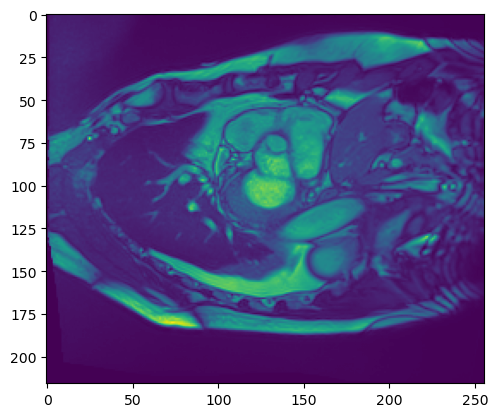

In [48]:
plt.imshow(img3[:,:,0])

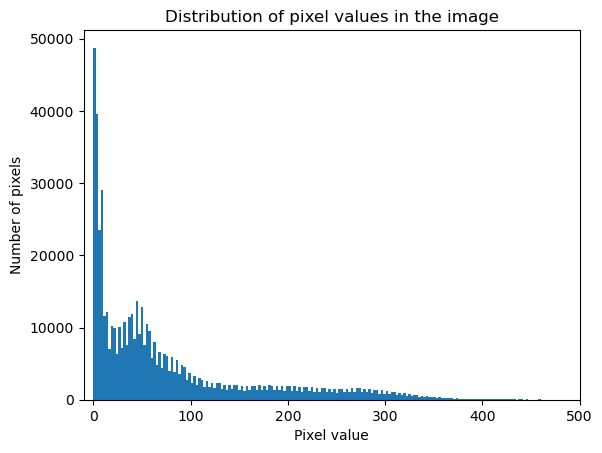

In [53]:
plt.hist(img3.flatten(), bins=256)
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.title('Distribution of pixel values in the image')
plt.xlim(-10,500)
plt.show()

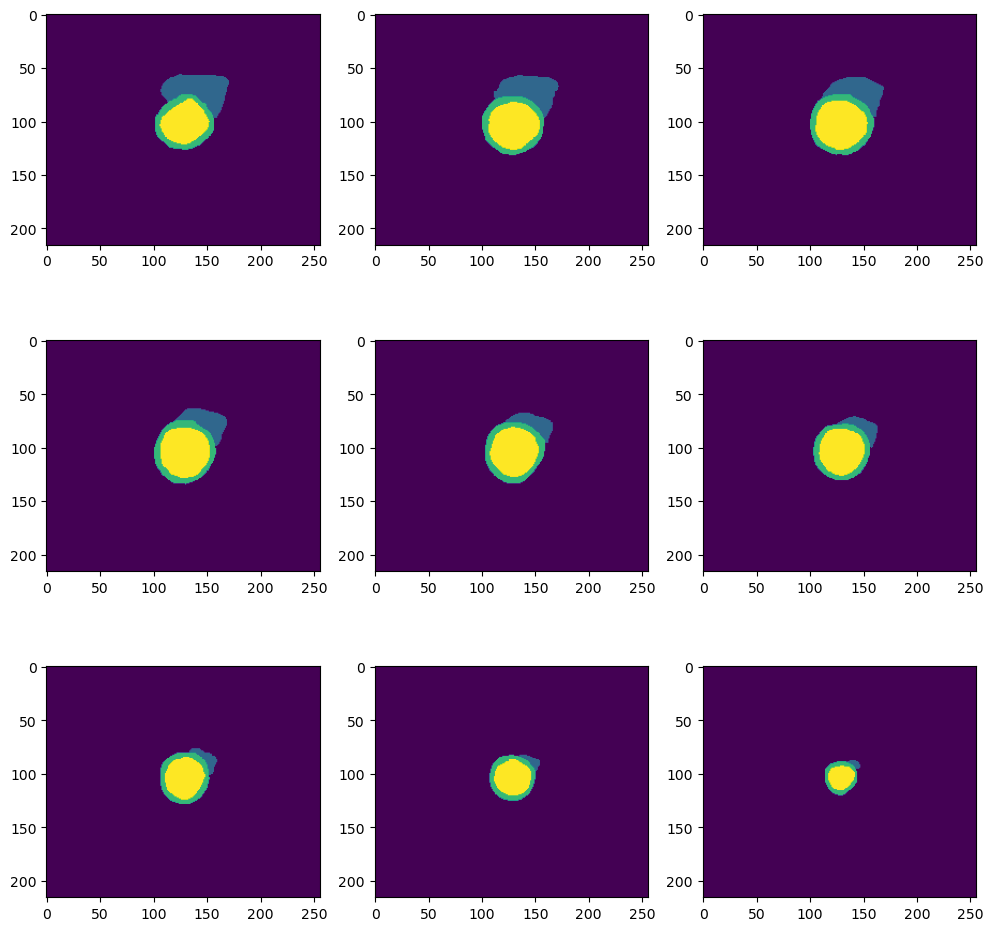

In [20]:
plt.style.use('default')
fig, axes = plt.subplots(3,3, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img2[:,:,1 + i])
plt.show()

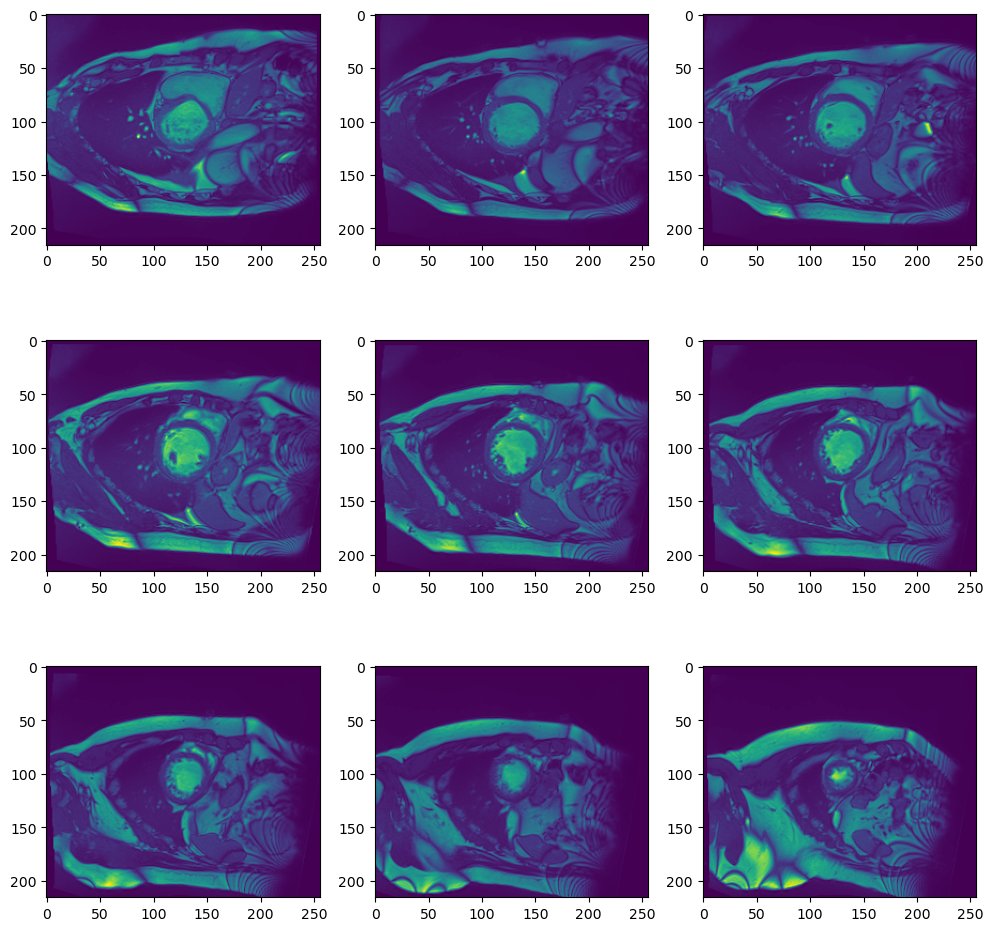

In [15]:
plt.style.use('default')
fig, axes = plt.subplots(3,3, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img3[:,:,1 + i])
plt.show()